# `Consignment Price Prediction`

## `Problem Statement`

* The market for logistics analytics is expected to develop at a CAGR of 17.3 percent
  from 2019 to 2024, more than doubling in size. This data demonstrates how logistics
  organizations are understanding the advantages of being able to predict what will
  happen in the future with a decent degree of certainty. Logistics leaders may use this
  data to address supply chain difficulties, cut costs, and enhance service levels all at the
  same time. The main goal is to predict the consignment pricing based on the available factors in the
  dataset.

In [1]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#import mlflow
from scipy import stats
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pandas_profiling import pandas_profiling
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from matplotlib.pyplot import figure


#mlflow.set_tracking_uri("sqlite:///consignment_price.db")
#mlflow.set_experiment("consignment-price-prediction")
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None

### `Load data`

In [2]:
df = pd.read_csv('./data/SCMS_Delivery_History_Dataset.csv')

In [3]:
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


### `Explore the data`

<AxesSubplot:>

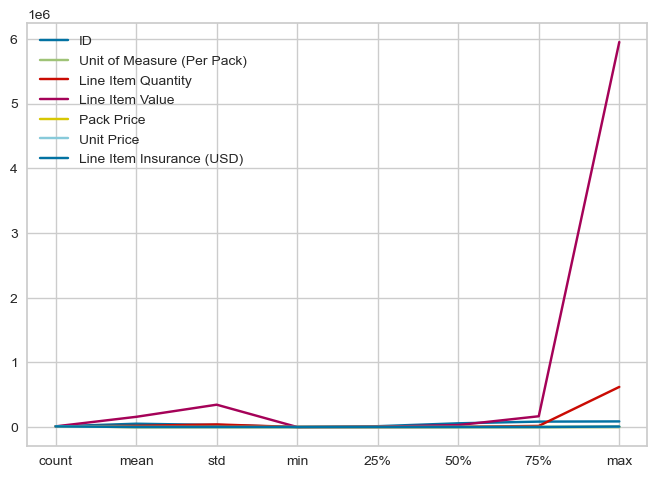

In [4]:
df.describe().plot.line()

In [5]:
df.describe()

,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.000000,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,51098.968229,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,31944.332496,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,12795.750000,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000
50%,57540.500000,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
75%,83648.250000,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000
max,86823.000000,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


In [6]:
df.shape

(10324, 33)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [8]:
df.nunique()

ID                              10324
Project Code                      142
PQ #                             1237
PO / SO #                        6233
ASN/DN #                         7030
Country                            43
Managed By                          4
Fulfill Via                         2
Vendor INCO Term                    8
Shipment Mode                       4
PQ First Sent to Client Date      765
PO Sent to Vendor Date            897
Scheduled Delivery Date          2006
Delivered to Client Date         2093
Delivery Recorded Date           2042
Product Group                       5
Sub Classification                  6
Vendor                             73
Item Description                  184
Molecule/Test Type                 86
Brand                              48
Dosage                             54
Dosage Form                        17
Unit of Measure (Per Pack)         31
Line Item Quantity               5065
Line Item Value                  8741
Pack Price  

In [9]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

### `Handling Null values`

In [10]:
def null_values(df, feature):
    match feature:
        case 'Line Item Insurance (USD)':
            df[feature] = df[feature].fillna(df['Line Item Insurance (USD)'].mode()[0])
            return df
        case 'Shipment Mode':
            df[feature]=df[feature].fillna("Other")
            return df
        case _:
            print('Error')

In [11]:
null_values(df, 'Line Item Insurance (USD)')
null_values(df, 'Shipment Mode')

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,0.00
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,0.00
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,0.00
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,0.00
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465

In [12]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                      0
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

### `Data Cleaning part_1`

In [13]:
def replace_strings(df, feature):
    match feature:
        case 'Freight Cost (USD)':
            df[feature]=df[feature].replace("Freight Included in Commodity Cost",0)
            df.loc[df[feature].str.contains('See', na=False), feature] = 'test'
            df[feature] = df[feature].replace('test', 0)
            return df
        case 'Weight (Kilograms)':
            df[feature] = df[feature].replace('Weight Captured Separately', 0)
            df.loc[df[feature].str.contains('See', na=False), feature] = 'test'
            df[feature] = df[feature].replace('test', 0)
            return df
        case _:
            print('Error')

In [14]:
replace_strings(df, 'Freight Cost (USD)')
replace_strings(df, 'Weight (Kilograms)')

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,0.00
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,0.00
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,0.00
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,0.00
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,0,0,705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,0,0,161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,0,0,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,0,134.03


In [15]:
df[df['First Line Designation'] == 'No']

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
8,46,112-NG-T01,Pre-PQ Process,SCMS-156,ASN-93,Nigeria,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,7-Dec-06,7-Dec-06,7-Dec-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,273,532.35,1.95,0.03,"Aurobindo Unit III, India",No,0,0,0.00
48,423,116-ZA-T01,Pre-PQ Process,SCMS-19800,ASN-1665,South Africa,PMO - US,Direct Drop,DDP,Truck,Pre-PQ Process,2/20/08,24-Apr-08,24-Apr-08,24-Apr-08,ARV,Pediatric,S. BUYS WHOLESALER,"Stavudine 1mg/ml [Zerit], powder for oral solu...",Stavudine,Zerit,1mg/ml,Powder for oral solution,200,600,870.00,1.45,0.01,"BMS Meymac, France",No,0,0,1.39
57,533,116-ZA-T01,Pre-PQ Process,SCMS-23500,ASN-2293,South Africa,PMO - US,Direct Drop,DDP,Truck,Pre-PQ Process,Date Not Captured,20-Aug-08,8-May-08,8-May-08,ARV,Pediatric,S. BUYS WHOLESALER,"Stavudine 1mg/ml [Zerit], powder for oral solu...",Stavudine,Zerit,1mg/ml,Powder for oral solution,200,670,1025.10,1.53,0.01,"BMS Meymac, France",No,0,0,1.64
78,837,116-ZA-T01,Pre-PQ Process,SCMS-33320,ASN-3553,South Africa,PMO - US,Direct Drop,DDP,Truck,Pre-PQ Process,Date Not Captured,17-May-09,9-Oct-08,9-Oct-08,ARV,Pediatric,S. BUYS WHOLESALER,"Stavudine 1mg/ml [Zerit], powder for oral solu...",Stavudine,Zerit,1mg/ml,Powder for oral solution,200,600,858.00,1.43,0.01,"BMS Meymac, France",No,0,0,1.68
79,838,116-ZA-T01,Pre-PQ Process,SCMS-33320,ASN-3553,South Africa,PMO - US,Direct Drop,DDP,Truck,Pre-PQ Process,Date Not Captured,17-May-09,9-Oct-08,9-Oct-08,ARV,Pediatric,S. BUYS WHOLESALER,"Didanosine 100mg [Videx],chewable tablets, 60 ...",Didanosine,Videx,100mg,Chewable/dispersible tablet,60,7,91.35,13.05,0.22,"BMS Meymac, France",No,0,0,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10318,86817,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,205243,738874.80,3.60,0.06,"Cipla, Goa, India",No,0,0,869.66
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,0,0,705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,0,0,161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,0,0,5284.04


In [16]:
df=df[(df["Freight Cost (USD)"]!='Invoiced Separately')]

In [17]:
df.shape

(10085, 33)

In [18]:
df['Freight Cost (USD)'].value_counts()

0           3887
9736.1        36
6147.18       27
7445.8        16
13398.06      16
            ... 
52057.8        1
4312.92        1
25129.15       1
4138.11        1
3410           1
Name: Freight Cost (USD), Length: 5433, dtype: int64

In [19]:
df['Freight Cost (USD)'] = df['Freight Cost (USD)'].astype('float')

In [20]:
df['Weight (Kilograms)'] = df['Weight (Kilograms)'].astype('float')

In [21]:
cons_price = df["Line Item Value"] + df["Freight Cost (USD)"] + df["Line Item Insurance (USD)"]

In [22]:
df['Consiment_price'] = cons_price

In [23]:
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Consiment_price
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.0,780.34,0.00,1331.34
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.0,4521.50,0.00,10721.50
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.0,1653.78,0.00,41653.78
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.0,16007.06,0.00,143367.86
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590.0,45450.08,0.00,167050.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,0.0,0.00,705.79,600361.39
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,0.0,0.00,161.71,137551.15
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,0.0,0.00,5284.04,5145398.78
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,My

## `EDA`

In [24]:
df['Shipment Mode'].value_counts(normalize=True) * 100

Air            58.730788
Truck          27.744175
Air Charter     6.425384
Other           3.569658
Ocean           3.529995
Name: Shipment Mode, dtype: float64

In [25]:
def value_count_norm(df, feature):
    value_count = df[feature].value_counts()
    value_count_norm_1 = df[feature].value_counts(normalize=True) * 100
    value_count_norm_1_concat = pd.concat([value_count, value_count_norm_1], axis=1)
    value_count_norm_1_concat.columns = ['Count', 'Frequency %']
    return value_count_norm_1_concat

In [26]:
value_count_norm(df, 'Shipment Mode')

,Count,Frequency %
Air,5923,58.730788
Truck,2798,27.744175
Air Charter,648,6.425384
Other,360,3.569658
Ocean,356,3.529995


In [27]:
value_count_norm(df, 'Fulfill Via')

,Count,Frequency %
From RDC,5328,52.830937
Direct Drop,4757,47.169063


In [28]:
value_count_norm(df, 'Managed By')

,Count,Frequency %
PMO - US,10026,99.414973
South Africa Field Office,57,0.565196
Haiti Field Office,1,0.009916
Ethiopia Field Office,1,0.009916


In [29]:
value_count_norm(df, 'First Line Designation')

,Count,Frequency %
Yes,6791,67.33763
No,3294,32.66237


In [30]:
value_count_norm(df, 'Vendor INCO Term')

,Count,Frequency %
N/A - From RDC,5328,52.830937
EXW,2640,26.177491
DDP,1443,14.308379
FCA,372,3.688647
CIP,275,2.726822
DDU,15,0.148736
DAP,9,0.089241
CIF,3,0.029747


In [31]:
value_count_norm(df, 'Sub Classification')

,Count,Frequency %
Adult,6486,64.313337
Pediatric,1914,18.978681
HIV test,1510,14.972732
HIV test - Ancillary,129,1.279127
Malaria,30,0.297471
ACT,16,0.158651


In [32]:
value_count_norm(df, 'Sub Classification').index

Index(['Adult', 'Pediatric', 'HIV test', 'HIV test - Ancillary', 'Malaria',
       'ACT'],
      dtype='object')

<AxesSubplot:>

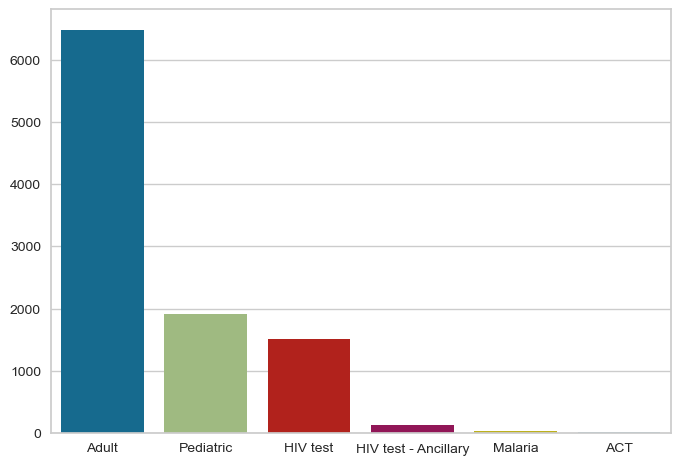

In [33]:
sns.barplot(x=value_count_norm(df, 'Sub Classification').index,y=value_count_norm(df, 'Sub Classification').values[:,0])